## Numerical integration: high-order quadratures

Recall some of the standard techniques for numerical integration that we covered:

- Rectangle rule

$$
\int_{a}^b f(x) \, dx \approx (b - a) \, f\left(\frac{a+b}{2}\right)~.
$$

<!-- $$
\int_a^b f(x) \approx h \sum_{k=1}^N f(x_k), \qquad k = 1,\ldots, N
$$
with
$$
h = (b-a)/N, \qquad x_k = a + \frac{2k-1}{2} h~.
$$ -->


- Trapezoidal rule

$$
\int_{a}^b f(x) \, dx \approx (b-a) \, \frac{f(a) + f(b)}{2}~.
$$

<!-- $$
\int_a^b f(x) \, dx\approx h \sum_{k=0}^N \frac{f(x_k) + f(x_{k+1})}{2}, \qquad i = 0,\ldots, N
$$
with
$$
h = (b-a)/N, \qquad x_k = a +  k h~.
$$ -->

- Simpson's rule

$$
\int_{a}^b f(x) \, dx \approx \frac{(b-a)}{6} \, \left[f(a) + 4 f \left( \frac{a+b}{2} \right) + f(b)\right].
$$


<!-- $$
\int_a^b f(x) \approx \frac{h}{3} \left[f(x_0) + 4 \sum_{k=1}^{N/2} f(x_{2k-1}) + 2 \sum_{k=1}^{N/2-1} f(x_{2k}) + f(x_N) \right],
$$
with
$$
h = (b-a)/N, \qquad x_k = a +  k h~.
$$ -->

All these rules can be written in a form
$$
\int_a^b f(x) \, dx \approx \sum_k w_k f(x_k),
$$
i.e. the integral is approximated as a sum integrand evaluations at various points with various weights.
In particular, we have
- Rectangle rule
$$
x_k = \{(a+b)/2\}, \qquad w_k = \{(b-a)\}
$$

- Trapezoidal rule
$$
x_k = \{a,~b\}, \qquad w_k = \{(b-a)/2,~(b-a)/2\}
$$

- Simpson's rule
$$
x_k = \{a,~(a+b)/2,~c\}, \qquad w_k = \{(b-a)/6,~2(b-a)/3,~(b-a)/6\}
$$

Different numerical schemes correspond to different choices of $x_k$ and $w_k$.

The only real constraint is that the sum of weights should be equal 
$$
\sum_k w_k = (b - a),
$$
such that the scheme gives correct result for the integration of a constant function.

## High-order quadratures

There is a systematic way to derive a numerical integration scheme 
$$
\int_a^b f(x) dx \approx \sum_k w_k f(x_k),
$$
which will give an exact result when the integrand $f(x)$ is a polynomial up to a certain degree.

Let us assume that $f(x)$ can be calculated at $N+1$ points inside the integration interval $(a,b)$.
Recall that function $f(x)$ evaluated at $N+1$ distinct points can be approximated by an interpolating polynomial of order $N$:
$$
f(x) \approx p_N(x) = \sum_{k=0}^{N} f(x_k) \, L_{N,k}(x)~.
$$
Here $L_{N,k}(x)$ are the Lagrange basis functions
$$
L_{N,k}(x) = \prod_{j\neq k} \frac{x-x_j}{x_k-x_j}.
$$

The approximation $f(x) \approx p_N(x)$ becomes exact when $f(x)$ is a polynomial of degree $N$.
Integrating $p_N(x)$ gives the following numerical quadrature:
$$
\int_a^b f(x) \, dx \approx \int_a^b p_N(x) \, dx = \sum_{k = 0}^N w_k f(x_k),
$$
where
$$
w_k = \int_a^b L_{N,k}(x) dx~.
$$

## Remapping

Note that one only really needs to calculate the quadratures (the nodes and weights) once for a single interval [typically  (-1.,1.)]. The corresponding $(-1,1)$ quadrature can always be mapped to any finite interval $(a,b)$ by the following tranformation
$$
x_k \to \frac{a+b}{2} + \frac{b-a}{2} x_k~,\\
w_k \to \frac{b-a}{2} w_k~.
$$

In [2]:
# Generic integration using quadratures
def integrate_quadrature(
    f,   # Function to be integrated 
    quad # A pair of lists (x,w) where x are the integration nodes and w are the weights 
                        ):
    ret = 0.
    n = len(quad[0])
    for k in range(n):
        xk = quad[0][k]
        wk = quad[1][k]
        ret += wk * f(xk)
    return ret

## Newton-Cotes quadratures

The simplest assumption is to take the $x_k$ to be distributed equidistantly.
This is called Newton-Cotes quadratures.
The integral is approximated as
$$
\int_a^b f(x) \, dx \approx \int_a^b p_N(x) \, dx = \sum_{k=0}^N w_k f(x_k),\\
w_k = \int_a^b L_{N,k}(x) dx~,
$$
but two scenarios are possible: the points $x_k$ either (a) include the endpoints $(a,b)$ or (b) exclude the endpoint.

In the case (a) we have closed Newton-Cotes quadrature
$$
x_k = a + h k, \qquad k = 0\ldots N, \qquad h = (b-a)/N,
$$
while in case (b) we have open Newton-Cotes quadrature
$$
x_k = a + h k, \qquad k = 1\ldots N+1, \qquad h = (b-a)/(N+2).
$$

The weights $w_k$ can be evaluated just once using e.g. one of the earlier developed methods of numerical integration.

The Newton-Cotes quadratures give exact answer for the integration of polynomials up to degree $N$.

In [3]:
import numpy as np

# Lagrange basis functions from Lecture 2
def Lnj(x,j,xdata):
    """Lagrange basis function."""
    ret = 1.
    for k in range(0, len(xdata)):
        if (k != j):
            ret *= (x - xdata[k]) / (xdata[j] - xdata[k])
    return ret

# Romberg method from previous lecture
# to calculate the weights wk
def romberg(
    f, 
    a, 
    b, 
    accuracy=1e-8,
    max_order=16,
    min_order=2
):
    R = np.zeros((max_order, max_order))
    h = (b - a) / 2.
    R[0, 0] = h * (f(a) + f(b)) # The initial trapezoidal rule   
    for n in range(1, max_order):
        trapezoid = 0.0
        for j in range(2**(n-1)):
            trapezoid += f(a + (2*j+1)*h)
        R[n, 0] = 0.5 * R[n-1, 0] + h * trapezoid # The trapezoidal rule
        l = 1
        # The Romberg iterations
        for m in range(1, n+1):
            l *= 4
            R[n, m] = (l * R[n, m-1] - R[n-1, m-1]) / (l-1)
        # print("Iteration: {0:5}, I = {1:20.15f}, error estimate = {2:10.15f}".format(n, R[n, m], abs(R[n, m] - R[n-1, m-1])))
        if abs(R[n, m] - R[n-1, m-1]) < accuracy and n > min_order:
            return R[n, m]
        h /= 2.
    print("Romberg method did not converge to required accuracy")
    return R[-1, -1]

# Calculating the weights using the Romberg method
# to requested accuracy for a given set of nodes x
# over the interval (a,b)
def compute_weights(x, 
                    a, 
                    b, 
                    tol = 1.e-15):
    ret = []
    for k in range(0,len(x)):
        tx = x
        def f(t):
            return Lnj(t, k, x)
        ret.append(romberg(f, a, b, tol))
    return ret

# Calculate the nodes and weights of either
# closed or open Newton-Cotes quadrature
# to requested accuracy
def newton_cotes(n, 
                 a = -1., 
                 b = 1., 
                 isopen = False, 
                 tol = 1.e-15):
    x = []
    if (isopen):
        h = (b - a) / (n + 2.)
        x = [a + (i+1)*h for i in range(0,n+1)]
    else:
        h = (b - a) / n
        x = [a + i*h for i in range(0,n+1)]
    return x, compute_weights(x, a, b, tol)

In [4]:
# Open Newton-Cotes rule with N = 0 gives the rectangle rule
newton_cotes(0, -1., 1., True)

([0.0], [2.0])

Gauss-Legendre quadratures from Mark Newman's book

In [5]:
# Closed Newton-Cotes rule with N = 1 gives the trapezoidal rule
newton_cotes(1, -1., 1., False)

([-1.0, 1.0], [1.0, 1.0])

In [6]:
# Closed Newton-Cotes rule with N = 2 gives the Simpson's rule
newton_cotes(2, -1., 1., False)

([-1.0, 0.0, 1.0],
 [0.3333333333333333, 1.3333333333333333, 0.3333333333333333])

In [7]:
# Visualize
import numpy as np

import matplotlib.pyplot as plt
# Default style parameters (feel free to modify as you see fit)
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'xtick.direction':'in',
         'ytick.direction':'in',
         }
plt.rcParams.update(params)

accuracy = 1.e-12

def quadrature_visualize(quad, a = -1., b = 1., title = "Quadrature"):
    n = len(quad[0])

    plt.xlabel("x")
    plt.ylabel("${w_k}$")
    plt.xlim(a,b)
    plt.title(title)
    for k in range(0,n):
        xk = quad[0][k]
        wk = quad[1][k]
        # print(xk," ",wk)
        plt.plot([xk,xk],[0.,wk], color = 'blue')
    plt.axhline(y = 0., color = 'black', linestyle = '--')
    
    return plt

Newton-Cotes quadrature permits negative weights

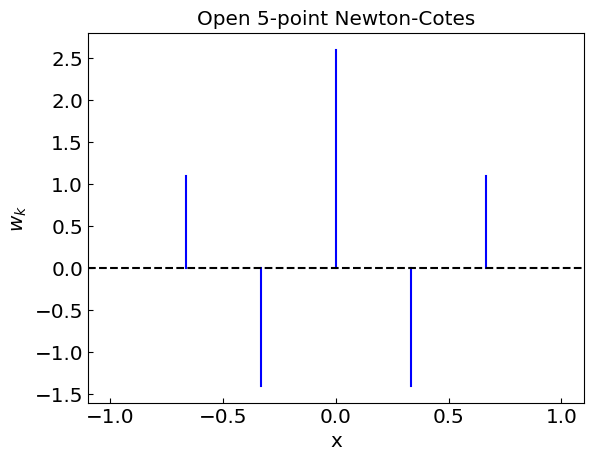

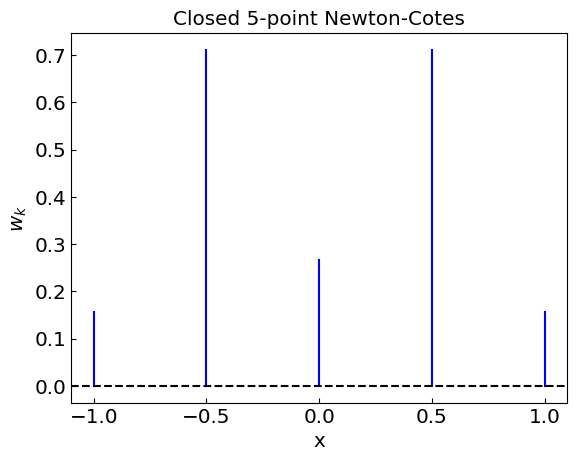

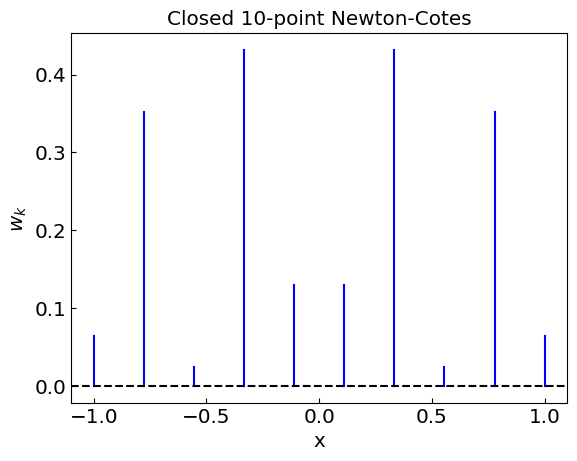

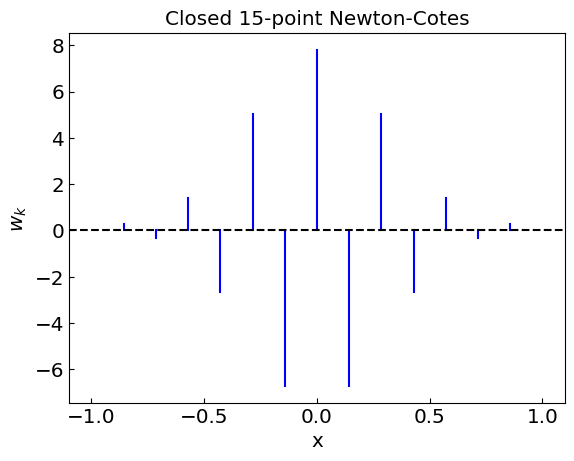

In [8]:
quadrature_visualize(newton_cotes(4, -1., 1., True), -1.1, 1.1, "Open 5-point Newton-Cotes").show()
quadrature_visualize(newton_cotes(4, -1., 1., False), -1.1, 1.1, "Closed 5-point Newton-Cotes").show()
quadrature_visualize(newton_cotes(9, -1., 1., False), -1.1, 1.1, "Closed 10-point Newton-Cotes").show()
quadrature_visualize(newton_cotes(14, -1., 1., False), -1.1, 1.1, "Closed 15-point Newton-Cotes").show()

Let us now apply Newton-Cotes quadratures to the integration of a polynomial we had before 

In [9]:
# Take our function example from last lecture
flabel = 'x^4 - 2x + 2'
def f(x):
    return x**4 - 2*x + 2
flimit_a = 0.
flimit_b = 2.

# Overwrite as applicable
# flabel = 'x^4 - 3x + 1'
# def f(x):
#     return x**4 - 3*x + 1
# flimit_a = 0.
# flimit_b = 2.

In [10]:
# Closed Newton-Cotes integration
print("Computing the integral of",flabel, "over the interval (",flimit_a,",",flimit_b,") using open Newton-Cotes quadratures")
print("{0:>10} {1:>20}".format("N", "I_N"))
for N in range(0,8):
    quadr = newton_cotes(N, flimit_a, flimit_b, True)
    integral = integrate_quadrature(f, quadr)
    print("{0:>10} {1:>20.16f}".format(N, integral))

Computing the integral of x^4 - 2x + 2 over the interval ( 0.0 , 2.0 ) using open Newton-Cotes quadratures
         N                  I_N
         0   2.0000000000000000
         1   3.3580246913580254
         2   6.1666666666666661
         3   6.2378666666666671
         4   6.4000000000000039
         5   6.3999999999999986
         6   6.4000000000000021
         7   6.4000000000000039


In [11]:
# Closed Newton-Cotes integration
print("Computing the integral of",flabel, "over the interval (",flimit_a,",",flimit_b,") using closed Newton-Cotes quadratures")
print("{0:>10} {1:>20}".format("N", "I_N"))
for N in range(1,8):
    quadr = newton_cotes(N, flimit_a, flimit_b, False)
    integral = integrate_quadrature(f, quadr)
    print("{0:>10} {1:>20.16f}".format(N, integral))

Computing the integral of x^4 - 2x + 2 over the interval ( 0.0 , 2.0 ) using closed Newton-Cotes quadratures
         N                  I_N
         1  16.0000000000000000
         2   6.6666666666666661
         3   6.5185185185185182
         4   6.4000000000000004
         5   6.4000000000000012
         6   6.3999999999999986
         7   6.4000000000000004


Newton-Cotes quadratures work well when the integrand is a polynomial since in this case the interpolating polynomial approximates the integrand exactly

However, issues may arise when the interpolating polynomial does not approximate the integrand well, as was in the case of Runge function

In [12]:
rungelabel = "Runge function"
def runge(x):
    return 1./(25*x**2 + 1.)

runge_a = -1.
runge_b = 1.

In [13]:
# Closed Newton-Cotes integration
print("Computing the integral of",rungelabel, "over the interval (",runge_a,",",runge_b,") using open Newton-Cotes quadratures")
print("{0:>10} {1:>20}".format("N", "I_N"))
for N in range(0,8):
    quadr = newton_cotes(N, runge_a, runge_b, True)
    integral = integrate_quadrature(runge, quadr)
    print("{0:>10} {1:>20.16f}".format(N, integral))

Computing the integral of Runge function over the interval ( -1.0 , 1.0 ) using open Newton-Cotes quadratures
         N                  I_N
         0   2.0000000000000000
         1   0.5294117647058825
         2  -0.2988505747126436
         3   0.2666666666666667
         4   2.0404749055585549
         5   0.9320668542657328
         6  -2.0045340869981669
         7  -0.1816307907657775


In [14]:
# Closed Newton-Cotes integration
print("Computing the integral of",rungelabel, "over the interval (",runge_a,",",runge_b,") using closed Newton-Cotes quadratures")
print("{0:>10} {1:>20}".format("N", "I_N"))
for N in range(1,15):
    quadr = newton_cotes(N, runge_a, runge_b, False)
    integral = integrate_quadrature(runge, quadr)
    print("{0:>10} {1:>20.16f}".format(N, integral))

Computing the integral of Runge function over the interval ( -1.0 , 1.0 ) using closed Newton-Cotes quadratures
         N                  I_N
         1   0.0769230769230769
         2   1.3589743589743588
         3   0.4162895927601810
         4   0.4748010610079575
         5   0.4615384615384615
         6   0.7740897346941600
         7   0.5797988819496757
         8   0.3000977814255821
         9   0.4797235795683667
        10   0.9346601111306989
        11   0.6489545880557170
        12  -0.0625873031506956
        13   0.3839594433665099
        14   1.5799089281703083


Integration of Runge's function using Newton-Cotes quadratures does not give an accurate answer because high oscillations at the edges of the integration. Romberg method on the other hand gives an accurate estimate

In [15]:
# Romberg method
print("Computing the integral of",rungelabel, "over the interval (",runge_a,",",runge_b,") using Romberg method")
print(romberg(runge, runge_a, runge_b))

Computing the integral of Runge function over the interval ( -1.0 , 1.0 ) using Romberg method
0.549360306777909


Newton-Cotes method can be improved by adjusting the choice of nodes. For instance, we learned that Chebyshed nodes minimize the Runge phenomenon. 

A quadrature based on Chebyshev nodes is called Clenshaw-Curtis quadrature. The weights of Clenshaw-Curtis quadrature can be efficiently computed using discrete cosine transform but for the present purposes we will using the straightforward numerical integration

In [16]:
def chebyshev_nodes(n,a,b):
    return [(a+b)/2. + (b-a) / 2. * np.cos((2.*k+1.)/(2.*n+2.)*np.math.pi) for k in range(n+1)]

def clenshaw_curtis(n, a = -1., b = 1., tol = 1.e-15):
    x = chebyshev_nodes(n,a,b)
    return x, compute_weights(x, a, b, tol)

/var/folders/3v/f0ynmrq5313979_z9dzqpvr00000gp/T/ipykernel_94314/1015787619.py:2: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  return [(a+b)/2. + (b-a) / 2. * np.cos((2.*k+1.)/(2.*n+2.)*np.math.pi) for k in range(n+1)]


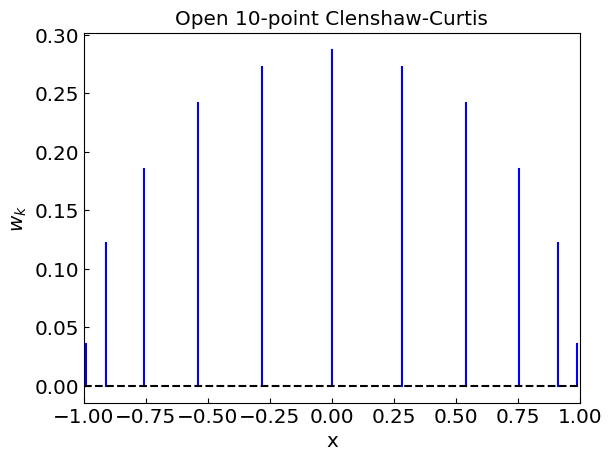

In [17]:
cc10 = clenshaw_curtis(10, -1., 1.)
quadrature_visualize(cc10, -1., 1., "Open 10-point Clenshaw-Curtis").show()

In [18]:
# Clenshaw-Curtis integration
print("Computing the integral of",rungelabel, "over the interval (",runge_a,",",runge_b,") using closed Clenshaw-Curtis quadratures")
print("{0:>10} {1:>20}".format("N", "I_N"))
for N in range(0,25):
    quadr = clenshaw_curtis(N, runge_a, runge_b)
    integral = integrate_quadrature(runge, quadr)
    print("{0:>10} {1:>20.16f}".format(N, integral))

Computing the integral of Runge function over the interval ( -1.0 , 1.0 ) using closed Clenshaw-Curtis quadratures
         N                  I_N
         0   2.0000000000000000
         1   0.1481481481481482
         2   1.1561181434599159
         3   0.3393357342937174
         4   0.7366108212029662
         5   0.4422623071358261
         6   0.6363602552248223
         7   0.4995830749190563
         8   0.5839263513091471
         9   0.5259711610228504
        10   0.5661564732597759
        11   0.5388727075897808
        12   0.5562316021895978
        13   0.5445109449451717
        14   0.5527811219474377
        15   0.5472112438100144
        16   0.5507349751776419
        17   0.5483645031315993
        18   0.5500702958302579
        19   0.5489233775473976
        20   0.5496321498366131
        21   0.5491557069456035


/var/folders/3v/f0ynmrq5313979_z9dzqpvr00000gp/T/ipykernel_94314/1015787619.py:2: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  return [(a+b)/2. + (b-a) / 2. * np.cos((2.*k+1.)/(2.*n+2.)*np.math.pi) for k in range(n+1)]


        22   0.5495101923607436
        23   0.5492719294992722
        24   0.5494126772553229


The Clenshaw-Curtis quadrature shows convergence, albeit a slow one

## Gaussian quadratures

## Gauss-Legendre quadrature

It turns out that the choice of nodes $x_k$ can be improved further upon such that an $n$-point quadrature
$$
\int_a^b f(x) dx \approx \sum_{k=1}^n w_k f(x_k)
$$
gives an exact result for any polynomial of degree $2n - 1$.

The derivation is a little bit tedious. 
First the integration range is taken as $(-1,1)$ [it always be rescaled back to $(a,b)$].
The outcome is that the nodes $x_k$ correspond to the roots of the Legendre polynomial $P_n(x)$.

The nodes $x_k$ can in principle be found as roots of $P_n(x)$ using the methods we developed earlier, while the weights $w_k$ are evaluated through numerical integration of Lagrange basis functions. $P_n(x)$ can itself be evaluated through a recurrence relation
$$
(n+1) P_{n+1}(x) = (2n+1) x P_n(x) - n P_{n-1}(x),
$$
starting from $P_0(x) = 1$ and $P_1(x) = x$.

This method is not the most efficient one and prone to large round-off error starting from ($n \sim 20$) (try it!).

More efficient methods exists. These calculate the roots of $P_n(x)$ using analytic approximation for the initial guess and
 use the recursion formula directly to calculate the $P_n(x)$ at given $x$ rather than for pre-calculating the polynomial coefficients. The weights can also be shown to be equal to
$$
w_k = \frac{2}{(1-x_k^2) [P'_n(x_k)]^2}~.
$$

An efficient implementation can be found in M. Newman "Computational Physics" textbook http://www-personal.umich.edu/~mejn/cp/programs/gaussxw.py

In [19]:
######################################################################
#
# Functions to calculate integration points and weights for Gaussian
# quadrature
#
# x,w = gaussxw(N) returns integration points x and integration
#           weights w such that sum_i w[i]*f(x[i]) is the Nth-order
#           Gaussian approximation to the integral int_{-1}^1 f(x) dx
# x,w = gaussxwab(N,a,b) returns integration points and weights
#           mapped to the interval [a,b], so that sum_i w[i]*f(x[i])
#           is the Nth-order Gaussian approximation to the integral
#           int_a^b f(x) dx
#
# This code finds the zeros of the nth Legendre polynomial using
# Newton's method, starting from the approximation given in Abramowitz
# and Stegun 22.16.6.  The Legendre polynomial itself is evaluated
# using the recurrence relation given in Abramowitz and Stegun
# 22.7.10.  The function has been checked against other sources for
# values of N up to 1000.  It is compatible with version 2 and version
# 3 of Python.
#
# Written by Mark Newman <mejn@umich.edu>, June 4, 2011
# You may use, share, or modify this file freely
#
######################################################################

from numpy import ones,copy,cos,tan,pi,linspace

def gaussxw(N):

    # Initial approximation to roots of the Legendre polynomial
    a = linspace(3,4*N-1,N)/(4*N+2)
    x = cos(pi*a+1/(8*N*N*tan(a)))

    # Find roots using Newton's method
    epsilon = 1e-15
    delta = 1.0
    while delta>epsilon:
        p0 = ones(N,float)
        p1 = copy(x)
        for k in range(1,N):
            p0,p1 = p1,((2*k+1)*x*p1-k*p0)/(k+1)
        dp = (N+1)*(p0-x*p1)/(1-x*x)
        dx = p1/dp
        x -= dx
        delta = max(abs(dx))

    # Calculate the weights
    w = 2*(N+1)*(N+1)/(N*N*(1-x*x)*dp*dp)

    return x,w

def gaussxwab(N,a,b):
    x,w = gaussxw(N)
    return 0.5*(b-a)*x+0.5*(b+a),0.5*(b-a)*w

In [20]:
print(gaussxw(1))
print(gaussxw(2))
print(gaussxw(3))

(array([-8.05825236e-16]), array([2.]))
(array([ 0.57735027, -0.57735027]), array([1., 1.]))
(array([ 7.74596669e-01, -8.96888137e-17, -7.74596669e-01]), array([0.55555556, 0.88888889, 0.55555556]))


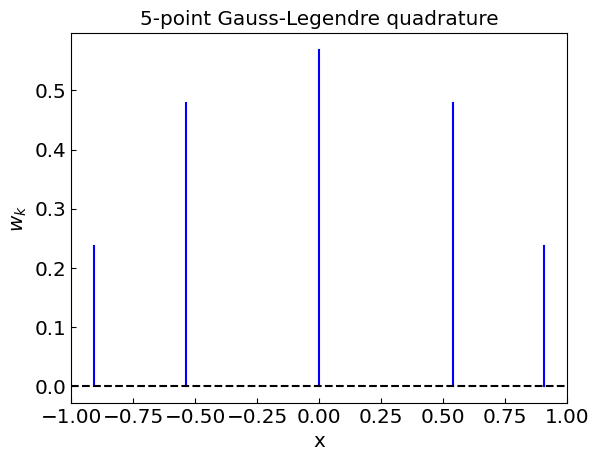

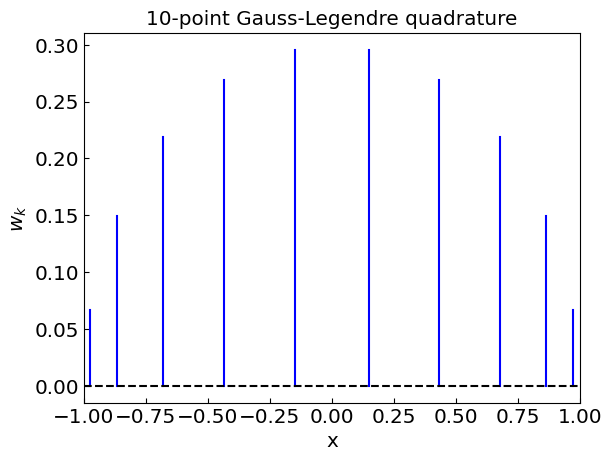

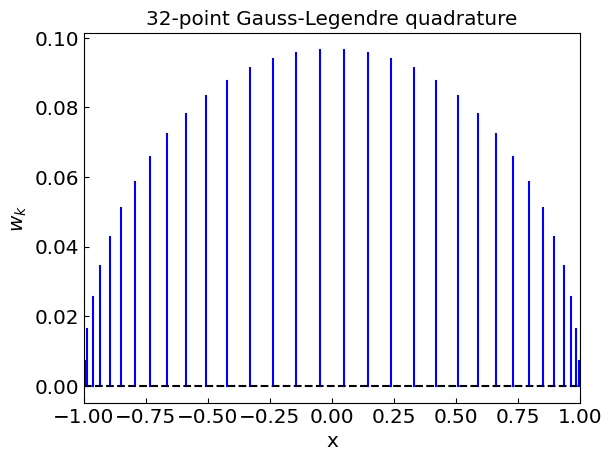

In [21]:
quadrature_visualize(gaussxw(5),  -1., 1.,  "5-point Gauss-Legendre quadrature").show()
quadrature_visualize(gaussxw(10), -1., 1., "10-point Gauss-Legendre quadrature").show()
quadrature_visualize(gaussxw(32), -1., 1., "32-point Gauss-Legendre quadrature").show()

In [22]:
# Gauss-Legendre quadrature integration
print("Computing the integral of",flabel, "over the interval (",flimit_a,",",flimit_b,") using Gauss-Legendre quadratures")
print("{0:>10} {1:>20}".format("N", "I_N"))
for N in range(1,8):
    quadr = gaussxwab(N, flimit_a, flimit_b)
    integral = integrate_quadrature(f, quadr)
    print("{0:>10} {1:>20.16f}".format(N, integral))

Computing the integral of x^4 - 2x + 2 over the interval ( 0.0 , 2.0 ) using Gauss-Legendre quadratures
         N                  I_N
         1   1.9999999999999969
         2   6.2222222222222303
         3   6.4000000000000066
         4   6.4000000000000208
         5   6.4000000000000190
         6   6.4000000000000021
         7   6.4000000000000083


From $N = 3$ the result is exact to machine precision!

In [23]:
# Another example, cubic function: trapezoidal rule vs 2-point gauss-legendre

def f2(x):
    return 7. * x**3 - 8. * x**2 - 3. * x + 3.

a = -1.
b = 1.

trapezoidal = newton_cotes(1, -1., 1., False)
clenshawcurtis = clenshaw_curtis(1, -1., 1.)
gaussn2 = gaussxwab(2, -1., 1.)

print("Computing the integral of","7x^3-8x^2-3x+3", "over the interval (",-1.,",",1.,")")
print("    Trapezoidal:", integrate_quadrature(f2, trapezoidal))
print("Clenshaw-Curtis:", integrate_quadrature(f2, clenshawcurtis))
print(" Gauss-Legendre:", integrate_quadrature(f2, gaussn2))

Computing the integral of 7x^3-8x^2-3x+3 over the interval ( -1.0 , 1.0 )
    Trapezoidal: -10.0
Clenshaw-Curtis: -2.0
 Gauss-Legendre: 0.6666666666666641


/var/folders/3v/f0ynmrq5313979_z9dzqpvr00000gp/T/ipykernel_94314/1015787619.py:2: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  return [(a+b)/2. + (b-a) / 2. * np.cos((2.*k+1.)/(2.*n+2.)*np.math.pi) for k in range(n+1)]


The exact result is $2/3$

## Generalized Gaussian quadratures

The method of Gaussian quadratures can be generalized to integrals of the following type
$$
\int_a^b \omega(x) f(x) dx \approx \sum_{k=1}^n w_k f(x_k)~.
$$

Here $a$ and $b$ need not necessarily have to correspond to a finite interval, and the integration of $f(x)$ is performed with a weight function $\omega(x)$. In this case it is possible to construct an $n$-point quadrature which provides exact answer when $f(x)$ is a polynomial of degree up to $2n - 1$. The weights $w_k$ are given by
$$
w_k = \int_a^b \omega(x) \, L_{{n-1},k}(x) \, dx~.
$$

Here $x_k$ correspond to the roots of a polynomial $p_n(x)$ satisfying the relation
$$
\int_a^b \omega(x) \, x^k \, p_n(x) \, dx = 0, \qquad k = 0,\ldots,n-1~.
$$

For $a = -1$, $b = 1$, and $\omega(x) = 1$, $p_n(x)$ corresponds to $n$th Legendre polynomial as discussed before.

Other common possibilities are
- Jacobi polynomials $P_n^{(\alpha,\beta)}(x)$
    - interval $(-1,1)$
    - $\omega(x) = (1-x)^\alpha \, (1+x)^{\beta}$
- Laguerre polynomials $L_n(x)$
    - interval $[0,\infty)$
    - $\omega(x) = e^{-x}$
- Hermite polynomials $H_n(x)$
    - interval $(-\infty, \infty)$
    - $\omega(x) = e^{-x^2}$
    
For all these cases efficient methods exist for calculating the nodes $x_k$ and the weights $\omega_k$ accurately. This calculation has to be done only once.

Below is an example for Laguerre and Hermite polynomials using sympy

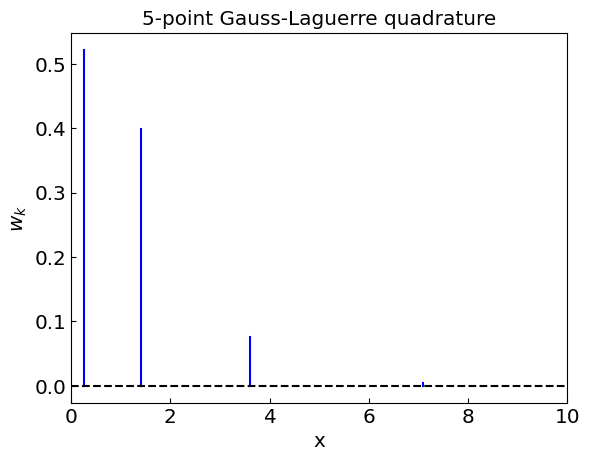

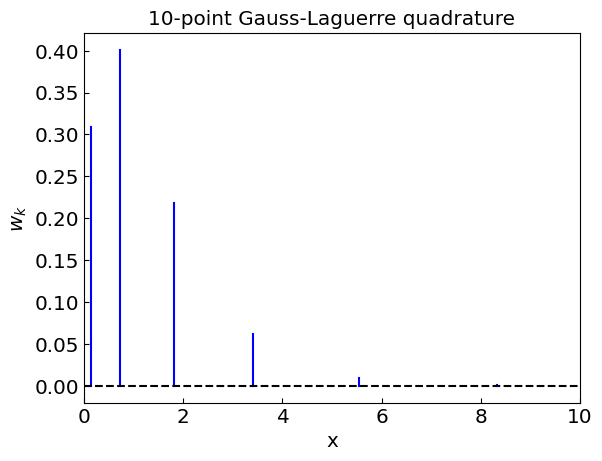

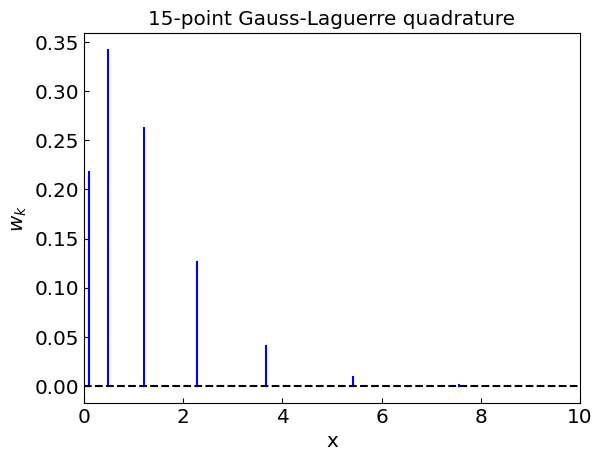

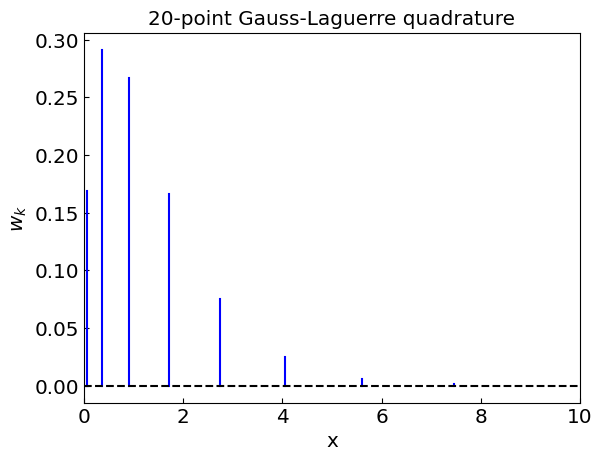

In [24]:
import sympy as sympy

# Nodes and weight for n-point Gauss-Laguerre quadrature
def laguerrexw(n):
    x = sympy.Symbol("x")
    roots = sympy.Poly(sympy.laguerre(n, x)).all_roots()
    x_i = [rt.evalf(20) for rt in roots]
    w_i = [(rt / ((n + 1) * sympy.laguerre(n + 1, rt)) ** 2).evalf(20) for rt in roots]
    return x_i, w_i

quadrature_visualize(laguerrexw(5), 0., 10., "5-point Gauss-Laguerre quadrature").show()
quadrature_visualize(laguerrexw(10), 0., 10., "10-point Gauss-Laguerre quadrature").show()
quadrature_visualize(laguerrexw(15), 0., 10., "15-point Gauss-Laguerre quadrature").show()
quadrature_visualize(laguerrexw(20), 0., 10., "20-point Gauss-Laguerre quadrature").show()

/var/folders/3v/f0ynmrq5313979_z9dzqpvr00000gp/T/ipykernel_94314/4028596385.py:8: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  w_i = [2**(n-1) * np.math.factorial(n) * np.sqrt(np.pi) / ((n**2) * sympy.hermite(n - 1, rt)**2).evalf(20) for rt in roots]


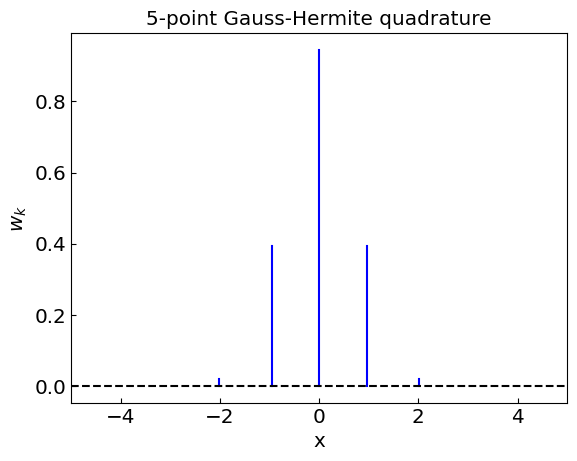

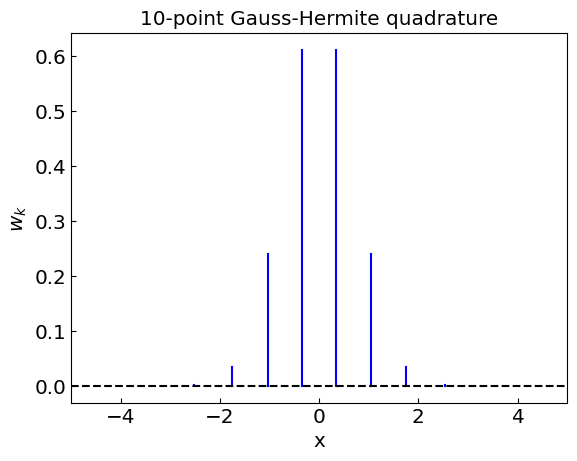

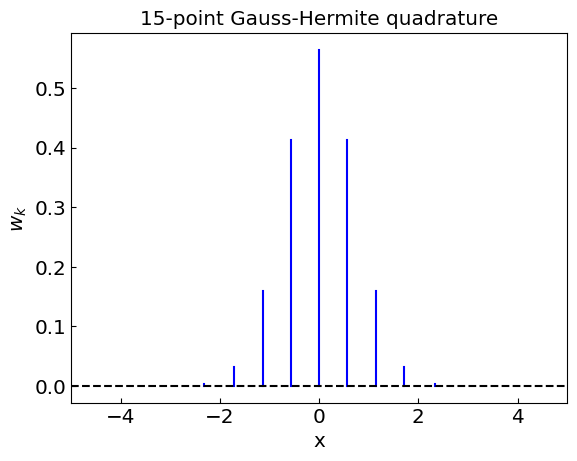

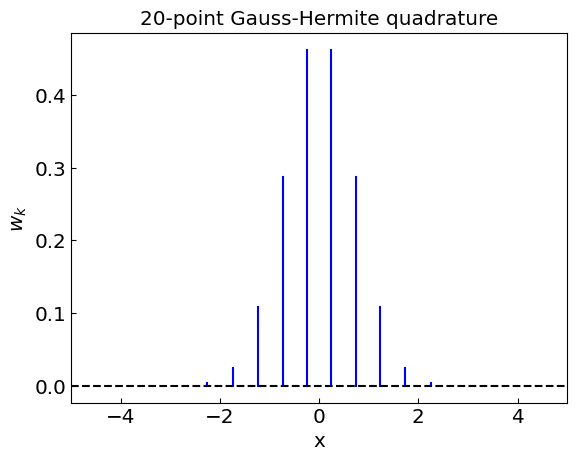

In [25]:
import sympy as sympy

# Nodes and weight for n-point Gauss-Laguerre quadrature
def hermitexw(n):
    x = sympy.Symbol("x")
    roots = sympy.Poly(sympy.hermite(n, x)).all_roots()
    x_i = [rt.evalf(20) for rt in roots]
    w_i = [2**(n-1) * np.math.factorial(n) * np.sqrt(np.pi) / ((n**2) * sympy.hermite(n - 1, rt)**2).evalf(20) for rt in roots]
    return x_i, w_i

quadrature_visualize(hermitexw(5),  -5., 5., "5-point Gauss-Hermite quadrature").show()
quadrature_visualize(hermitexw(10), -5., 5., "10-point Gauss-Hermite quadrature").show()
quadrature_visualize(hermitexw(15), -5., 5., "15-point Gauss-Hermite quadrature").show()
quadrature_visualize(hermitexw(20), -5., 5., "20-point Gauss-Hermite quadrature").show()